# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from preprocessing import *
from logistic_regression import LogisticRegressionScratch
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score , log_loss , confusion_matrix
from knn import KNNClassifier
import random
##################################################
import optuna
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

try:
    import cupy as cp
    xp = cp  # use CuPy if available
    print("Running LogisticRegressionScratch on GPU")
except ImportError:
    import numpy as np
    xp = np  # fallback to CPU
    print("CuPy not installed, running on CPU")

Running LogisticRegressionScratch on GPU


/media/hodhod/Youssef/MIA/Electrical/Phase-2/Task 10/Task 10_2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Exploring


   age     sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0   52  female   0       125   212    0        1      168      0      1.0   
1   53  female   0       140   203    1        0      155      1      3.1   
2   70  female   0       145   174    0        1      125      1      2.6   
3   61  female   0       148   203    0        1      161      0      0.0   
4   62    male   0       138   294    1        1      106      0      1.9   

   slope  ca  thal  target  
0      2   2     3       0  
1      0   0     3       0  
2      0   0     3       0  
3      2   1     3       0  
4      1   3     2       0  
               age           cp     trestbps        chol          fbs  \
count  1025.000000  1025.000000  1025.000000  1025.00000  1025.000000   
mean     54.434146     0.942439   131.611707   246.00000     0.149268   
std       9.072290     1.029641    17.516718    51.59251     0.356527   
min      29.000000     0.000000    94.000000   126.00000     0.000000  

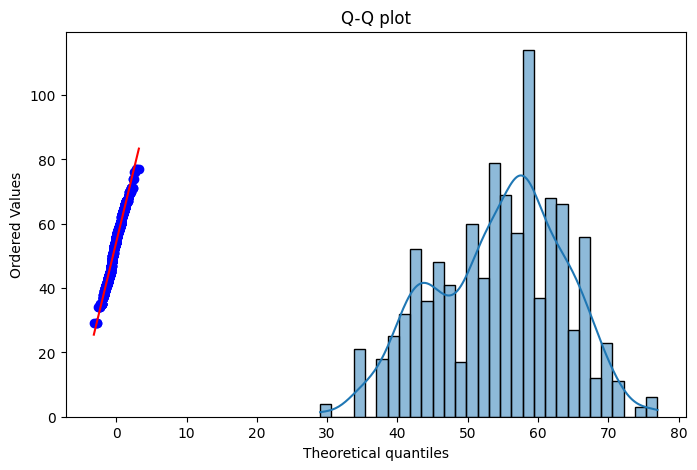

Skewness for age = -0.24850155959576398


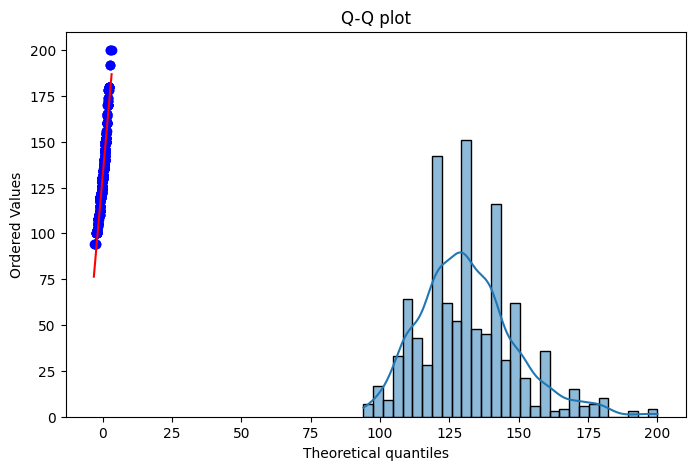

Skewness for trestbps = 0.7386851980251403


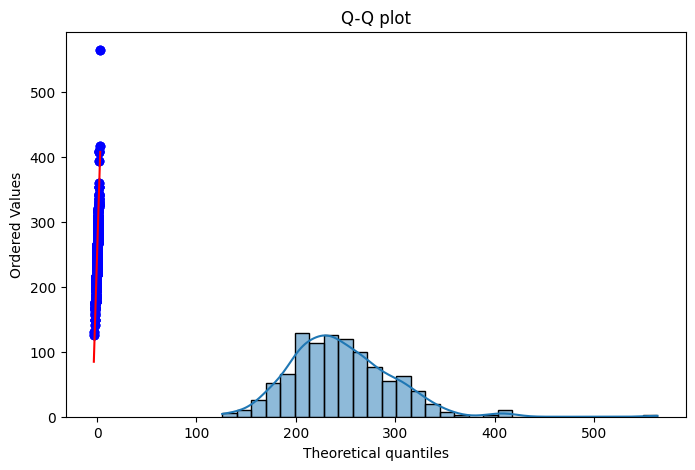

Skewness for chol = 1.0725003251281213


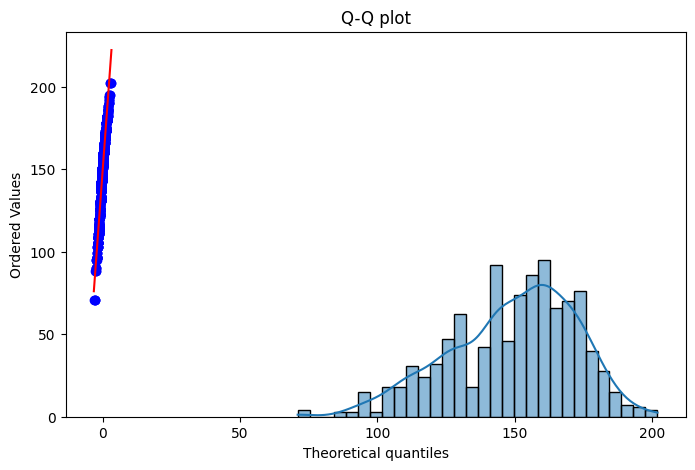

Skewness for thalach = -0.5130250022552884


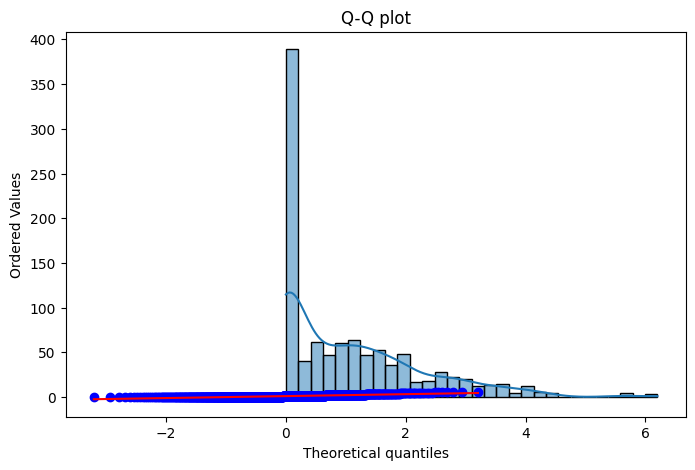

Skewness for oldpeak = 1.2091266194843548


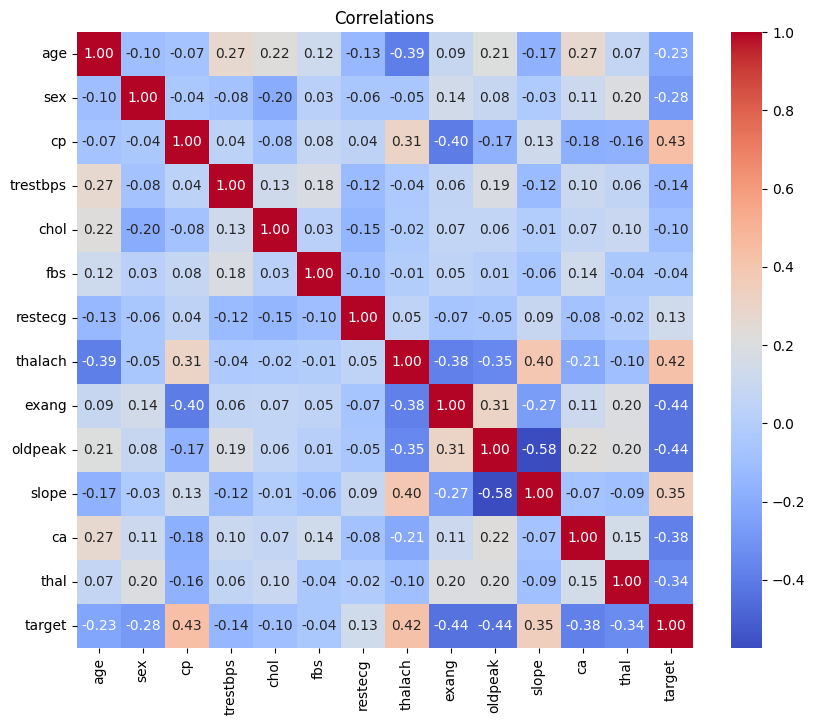

OUTLIERS
age: 0 outliers
trestbps: 30 outliers
chol: 16 outliers
thalach: 4 outliers
oldpeak: 7 outliers
[636, 257, 896, 641, 137, 393, 267, 396, 526, 528, 151, 665, 29, 158, 542, 294, 679, 296, 685, 47, 175, 688, 944, 179, 436, 559, 54, 55, 958, 192, 833, 450, 578, 452, 837, 326, 69, 971, 464, 87, 343, 986, 609, 481, 996, 229, 613, 123, 496, 624, 246, 889, 378, 891, 508, 509, 255]


In [2]:
df = load_data("Heart-Disease-dataset.csv")
print (df.head())
print(df.describe())
print (df.info())

#plotting
numerical_cols = ["age","trestbps" , "chol" , "thalach" ,"oldpeak"]
logical_cols = ["cp" , "exang" , "slope" , "ca","thal"]
encoded_cols =["sex"]

#encoding coded cols
for col in encoded_cols :
    df["sex"] = df["sex"].map({"male": 0, "female": 1}) #male into 0 women into 1


for col in numerical_cols :
    ##Histograms to check initially
    plt.figure(figsize=(8,5))
    sns.histplot(df[col] , kde=True , bins= 30)


    ## checking from skewness
    stats.probplot(df[col] , dist = 'norm' , plot=plt)
    plt.title("Q-Q plot")
    plt.show()
    print (f"Skewness for {col} = {skew(df[col])}") #trestbps,oldpeak and chol could be fixed -they're slightly skewed ,
                                                    
    plt.show()

skewed_list =  ["trestbps" , "oldpeak", "chol"]

#Checking corelations 
plt.figure(figsize=(10,8))
corr_matrix = df[df.columns].corr()
sns.heatmap(corr_matrix , annot=True , fmt=".2f" , cmap="coolwarm" , cbar= True , square= True)
plt.title("Correlations")                              
plt.show()                                             #fbs and restecg are weakly related to everything , worthy to exepermient with them deleted        

corelation_cols = ["fbs", "restecg"]

##checking outliers 
def detect_outliers_iqr(df, cols):
    outlier_indices = set()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        print(f"{col}: {len(outliers_col)} outliers")
        outlier_indices.update(outliers_col)
    return list(outlier_indices)

print("OUTLIERS")
print(detect_outliers_iqr(df , numerical_cols))   #yea fbs is just noisy , ca can be clipped

In [3]:
df_cleaned = cleaning(df, digital_cols=logical_cols, corelation_cols=corelation_cols,
                      numerical_cols=numerical_cols, skewed_cols=skewed_list)
X_all_np, y_all_np, scaler = normalization(df_cleaned, numerical_cols=numerical_cols,
                                     digital_cols=logical_cols, target_col="target")  # adapt names if your function differs

# normalization returned arrays (or DataFrame) — make sure they are numpy arrays for kf
X_all_np = np.array(X_all_np)
y_all_np = np.array(y_all_np).ravel()

# create xp copies for fast GPU ops (if xp is CuPy it will copy to GPU)
X_all = xp.array(X_all_np)
y_all = xp.array(y_all_np)

# Grid search

## using logistic regression

In [ ]:
#params to try
param_grid = {
    'learning_rate': [0.001,0.01,0.05,0.1],
    'epochs':        [50,100,200],
    'reg_l1':        [0.0, 1e-4, 1e-3, 1e-2],
    'reg_l2':        [0.0, 1e-4, 1e-3, 1e-2],
    'batch_size': [32, 128 , 1026]
}

thresholds = np.arange(0.3,0.8,0.05)  #thresholds for evaluation (kept on CPU for sklearn)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# incremental output file
out_csv = "all_results_incremental_gpu_with_low_dataset_recs.csv"
if not os.path.exists(out_csv):
    pd.DataFrame(columns=['learning_rate','epochs','reg_l1','reg_l2','batch_size','threshold',
                          'acc','prec','rec','f1','log_loss','overall']).to_csv(out_csv, index=False)

results = []
best_overall = -1
best_config = None
counter = 0

# evaluates a single fold ---
def evaluate_fold_indices(train_idx, val_idx, lr, ep, l1, l2, batch_size):
    # Using xp arrays (GPU) for model inputs
    X_train = X_all[train_idx]
    y_train = y_all[train_idx]
    X_val = X_all[val_idx]
    y_val = y_all[val_idx]

    model = LogisticRegressionScratch(learning_rate=lr, epochs=ep, reg_l1=l1, reg_l2=l2)
    model.fit_advanced(X_train, y_train, shuffle=True, minibatch=True, batch_size=batch_size)

    prob_val_xp = model.predict_proba(X_val)  # xp array
    #move probabilities and labels to CPU numpy for sklearn metrics
    prob_val = xp.asnumpy(prob_val_xp) if hasattr(xp, 'asnumpy') else prob_val_xp
    y_val_cpu = xp.asnumpy(y_val) if hasattr(xp, 'asnumpy') else y_val
    return y_val_cpu, prob_val

#Grid search
for lr in param_grid['learning_rate']:
    for ep in param_grid['epochs']:
        for l1 in param_grid['reg_l1']:
            for l2 in param_grid['reg_l2']:
                for batch in param_grid['batch_size']:
                    y_trues_list = []
                    y_probs_list = []

                    #run CV folds
                    for tr_idx, vl_idx in kf.split(X_all_np, y_all_np):  # kf needs numpy arrays/indices
                        y_val, prob_val = evaluate_fold_indices(tr_idx, vl_idx, lr, ep, l1, l2, batch)
                        y_trues_list.append(y_val)
                        y_probs_list.append(prob_val)

                    y_trues = np.concatenate(y_trues_list)
                    y_probs = np.concatenate(y_probs_list)

                    #optimize threshold on CV predictions (CPU)
                    best_f1 = -1.0
                    best_th = 0.5
                    for th in thresholds:
                        y_pred = (y_probs >= th).astype(int)
                        f1 = f1_score(y_trues, y_pred)
                        if f1 > best_f1:
                            best_f1 = f1
                            best_th = float(th)

                    #compute final metrics at best threshold
                    y_pred = (y_probs >= best_th).astype(int)
                    acc = accuracy_score(y_trues, y_pred)
                    prec = precision_score(y_trues, y_pred, zero_division=0)
                    rec = recall_score(y_trues, y_pred, zero_division=0)
                    f1v = f1_score(y_trues, y_pred)
                    logloss = log_loss(y_trues, y_probs)

                    # overall score
                    overall = 0.15*acc + 0.2*prec + 0.15*rec + 0.25*f1v + 0.25*(1 - logloss / np.log(2))

                    #update best
                    if overall > best_overall:
                        best_overall = overall
                        best_config = {'learning_rate': lr, 'epochs': ep, 'reg_l1': l1, 'reg_l2': l2,
                                       'batch_size': batch, 'threshold': best_th,
                                       'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1v, 'log_loss': logloss}
                        print(f"[NEW BEST] overall={overall:.4f} | lr={lr}, ep={ep}, λ1={l1}, λ2={l2}, batch={batch}, th={best_th:.2f}")

                    #append and sav
                    row = {'learning_rate': lr, 'epochs': ep, 'reg_l1': l1, 'reg_l2': l2,
                           'batch_size': batch, 'threshold': best_th,
                           'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1v, 'log_loss': logloss, 'overall': overall}
                    results.append(row)
                    pd.DataFrame([row]).to_csv(out_csv, mode='a', header=False, index=False)

                    counter += 1
                    if counter % 5 == 0:
                        print(f"{counter} configs done")
                        
df_results = pd.DataFrame(results)
df_results.to_csv("all_results_ranked_gpu.csv", index=False)
top5 = df_results.sort_values('f1', ascending=False).head(5)
print("\nTop 5 configurations:")
print(top5)
print("\nBest config summary:")
print(best_config)

[SGD] Epoch    0: loss=0.692118
[SGD] Epoch    0: loss=0.692028
[SGD] Epoch    0: loss=0.692124
[SGD] Epoch    0: loss=0.692191
[SGD] Epoch    0: loss=0.692033
[NEW BEST] overall=0.5551 | lr=0.001, ep=50, λ1=0.0, λ2=0.0, batch=32, th=0.50
[SGD] Epoch    0: loss=0.692869
[SGD] Epoch    0: loss=0.692845
[SGD] Epoch    0: loss=0.692869
[SGD] Epoch    0: loss=0.692892
[SGD] Epoch    0: loss=0.692852
[SGD] Epoch    0: loss=0.693108
[SGD] Epoch    0: loss=0.693104
[SGD] Epoch    0: loss=0.693107
[SGD] Epoch    0: loss=0.693110
[SGD] Epoch    0: loss=0.693104
[SGD] Epoch    0: loss=0.692126
[SGD] Epoch    0: loss=0.692038
[SGD] Epoch    0: loss=0.692123
[SGD] Epoch    0: loss=0.692187
[SGD] Epoch    0: loss=0.692025
[NEW BEST] overall=0.5551 | lr=0.001, ep=50, λ1=0.0, λ2=0.0001, batch=32, th=0.50
[SGD] Epoch    0: loss=0.692869
[SGD] Epoch    0: loss=0.692848
[SGD] Epoch    0: loss=0.692864
[SGD] Epoch    0: loss=0.692882
[SGD] Epoch    0: loss=0.692842
5 configs done
[SGD] Epoch    0: loss=0

In [5]:
#not a big difference using low recs reccomendation
results_by_grid_search = pd.read_csv("all_results_incremental_gpu.csv")

best_logloss = results_by_grid_search.sort_values(by="log_loss").head(1)
best_overall = results_by_grid_search.sort_values(by="overall").tail(1)

print (f"_______Best logloss______\n {best_logloss}\n")
print (f"_______Best overall______\n {best_overall}")

_______Best logloss______
      learning_rate  epochs  reg_l1  reg_l2  batch_size  threshold       acc  \
399            0.5     100   0.001   0.001          16        0.4  0.724878   

         prec       rec        f1  log_loss   overall  
399  0.684848  0.859316  0.762226  0.542703  0.619417  

_______Best overall______
      learning_rate  epochs  reg_l1  reg_l2  batch_size  threshold       acc  \
219            0.1     100    0.01   0.001          16        0.4  0.733659   

         prec       rec        f1  log_loss   overall  
219  0.686303  0.885932  0.773444  0.548233  0.625827  


## Using KNN

In [ ]:
results = []  # store all results
csv_file = "All results KNN.csv"

def evaluate_fold(tr_idx, vl_idx, k):
    X_train, X_val = X_all_np[tr_idx], X_all_np[vl_idx]
    y_train, y_val = y_all_np[tr_idx], y_all_np[vl_idx]

    model = KNNClassifier(k=k)
    model.fit(X_train, y_train)

    prob_val = model.predict_proba(X_val)
    y_pred = model.predict(X_val)

    return y_val, prob_val, y_pred

kf = KFold(n_splits=5, shuffle=True, random_state=42)

#try with k values from 1 to 10
for k in range (1,11):
    y_trues, y_probs, y_preds = [], [], []

    for tr_idx, vl_idx in kf.split(X_all_np, y_all_np):
        y_val, prob_val, y_pred = evaluate_fold(tr_idx, vl_idx, k)
        y_trues.extend(y_val)
        y_probs.extend(prob_val)
        y_preds.extend(y_pred)

    acc = accuracy_score(y_trues, y_preds)
    prec = precision_score(y_trues, y_preds)
    rec = recall_score(y_trues, y_preds)
    f1v = f1_score(y_trues, y_preds)
    loss = log_loss(y_trues, y_probs)

    #overall score
    overall = (
        0.15 * acc +
        0.20 * prec +
        0.15 * rec +
        0.25 * f1v +
        0.25 * (1 - loss / np.log(2))
    )

    row = {
        "k": k,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1v,
        "log_loss": loss,
        "overall": overall,
    }
    results.append(row)

    #save during runtime
    df_tmp = pd.DataFrame([row])
    if os.path.exists(csv_file):
        df_tmp.to_csv(csv_file, mode="a", header=False, index=False)
    else:
        df_tmp.to_csv(csv_file, index=False)

    print(f"Saved partial results after k={k}: overall={overall:.4f}")

# Final DataFrame in memory
df_results = pd.DataFrame(results)
print("\n✅ Grid search completed. Results saved to:", csv_file)

Saved partial results after k=1: overall=0.9599
Saved partial results after k=2: overall=0.9079
Saved partial results after k=3: overall=0.8466
Saved partial results after k=4: overall=0.7908
Saved partial results after k=5: overall=0.7052
Saved partial results after k=6: overall=0.6823
Saved partial results after k=7: overall=0.6747
Saved partial results after k=8: overall=0.6756
Saved partial results after k=9: overall=0.6579
Saved partial results after k=10: overall=0.6607

✅ Grid search completed. Results saved to: All results KNN.csv


In [7]:
#not a big difference using low recs reccomendation
results_by_grid_search = pd.read_csv("All results KNN.csv")

best_logloss = results_by_grid_search.sort_values(by="log_loss").head(3)


print (f"_______Best logloss______\n {best_logloss}\n")  #using k = 1feels overfitting

_______Best logloss______
     k  accuracy  precision    recall       f1  log_loss   overall
0   1  0.997073        1.0  0.994297  0.99714  0.105494  0.959942
10  1  0.997073        1.0  0.994297  0.99714  0.105494  0.959942
20  1  0.997073        1.0  0.994297  0.99714  0.105494  0.959942



# Random search

In [8]:
n_trials = 500
out_csv = "random_search.csv"

# create CSV with headers if it doesn't exist
if not os.path.exists(out_csv):
    pd.DataFrame(columns=['learning_rate','epochs','reg_l1','reg_l2','batch_size','threshold',
                          'acc','prec','rec','f1','log_loss','overall']).to_csv(out_csv, index=False)

results = []
best_overall = -1
best_config = None

# --- define ranges ---
param_ranges = {
    "learning_rate": (1e-4, 1e-1),   # log-uniform range
    "epochs": (50, 300),             # integer range
    "reg_l1": (0.0, 1e-2),           # uniform range
    "reg_l2": (0.0, 1e-2),           # uniform range
    "batch_size": (32, 1024)         # integer range
}

def sample_params():
    # log-uniform for learning_rate
    lr = 10 ** random.uniform(np.log10(param_ranges["learning_rate"][0]),
                              np.log10(param_ranges["learning_rate"][1]))
    # integers
    ep = random.randint(*param_ranges["epochs"])
    batch = random.randint(*param_ranges["batch_size"])
    # floats uniform
    l1 = random.uniform(*param_ranges["reg_l1"])
    l2 = random.uniform(*param_ranges["reg_l2"])
    return lr, ep, l1, l2, batch

for trial in range(n_trials):
    # --- sample random config ---
    lr, ep, l1, l2, batch = sample_params()

    y_trues_list, y_probs_list = [], []

    # run CV folds
    for tr_idx, vl_idx in kf.split(X_all_np, y_all_np):
        y_val, prob_val = evaluate_fold_indices(tr_idx, vl_idx, lr, ep, l1, l2, batch)
        y_trues_list.append(y_val)
        y_probs_list.append(prob_val)

    y_trues = np.concatenate(y_trues_list)
    y_probs = np.concatenate(y_probs_list)

    # optimize threshold
    best_f1 = -1.0
    best_th = 0.5
    for th in thresholds:
        y_pred = (y_probs >= th).astype(int)
        f1 = f1_score(y_trues, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = float(th)

    # final metrics at best_th
    y_pred = (y_probs >= best_th).astype(int)
    acc = accuracy_score(y_trues, y_pred)
    prec = precision_score(y_trues, y_pred, zero_division=0)
    rec = recall_score(y_trues, y_pred, zero_division=0)
    f1v = f1_score(y_trues, y_pred)
    logloss = log_loss(y_trues, y_probs)

    overall = 0.15*acc + 0.2*prec + 0.15*rec + 0.25*f1v + 0.25*(1 - logloss / np.log(2))

    if overall > best_overall:
        best_overall = overall
        best_config = {'learning_rate': lr, 'epochs': ep, 'reg_l1': l1, 'reg_l2': l2,
                       'batch_size': batch, 'threshold': best_th,
                       'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1v, 'log_loss': logloss}
        print(f"[NEW BEST] overall={overall:.4f} | lr={lr:.5f}, ep={ep}, λ1={l1:.5e}, λ2={l2:.5e}, batch={batch}, th={best_th:.2f}")

    # append & save incrementally
    row = {'learning_rate': lr, 'epochs': ep, 'reg_l1': l1, 'reg_l2': l2,
           'batch_size': batch, 'threshold': best_th,
           'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1v, 'log_loss': logloss, 'overall': overall}
    results.append(row)
    pd.DataFrame([row]).to_csv(out_csv, mode='a', header=False, index=False)

    if (trial+1) % 5 == 0:
        print(f"{trial+1}/{n_trials} random configs done")

# --- 5) Final ranked save ---
df_results = pd.DataFrame(results)
df_results.to_csv("random_search_ranked.csv", index=False)

[SGD] Epoch    0: loss=0.693083
[SGD] Epoch  100: loss=0.686969
[SGD] Epoch    0: loss=0.693093
[SGD] Epoch  100: loss=0.687919
[SGD] Epoch    0: loss=0.693090
[SGD] Epoch  100: loss=0.687613
[SGD] Epoch    0: loss=0.693090
[SGD] Epoch  100: loss=0.687703
[SGD] Epoch    0: loss=0.693083
[SGD] Epoch  100: loss=0.686950
[NEW BEST] overall=0.5427 | lr=0.00075, ep=184, λ1=4.35300e-03, λ2=6.95556e-03, batch=416, th=0.50
[SGD] Epoch    0: loss=0.691660
[SGD] Epoch  100: loss=0.612055
[SGD] Epoch    0: loss=0.691885
[SGD] Epoch  100: loss=0.623060
[SGD] Epoch    0: loss=0.691813
[SGD] Epoch  100: loss=0.619140
[SGD] Epoch    0: loss=0.691834
[SGD] Epoch  100: loss=0.621612
[SGD] Epoch    0: loss=0.691657
[SGD] Epoch  100: loss=0.611709
[NEW BEST] overall=0.5771 | lr=0.03420, ep=105, λ1=5.43205e-03, λ2=9.17489e-03, batch=850, th=0.45
[SGD] Epoch    0: loss=0.690493
[SGD] Epoch  100: loss=0.591398
[SGD] Epoch  200: loss=0.568590
[SGD] Epoch    0: loss=0.690827
[SGD] Epoch  100: loss=0.606162
[S

# Visualization 


[SGD] Epoch    0: loss=0.668293
[SGD] Epoch  100: loss=0.562565
[SGD] Epoch    0: loss=0.665791
[SGD] Epoch  100: loss=0.554197
[SGD] Epoch    0: loss=0.666921
[SGD] Epoch  100: loss=0.561909
[SGD] Epoch    0: loss=0.671043
[SGD] Epoch  100: loss=0.565012
[SGD] Epoch    0: loss=0.665243
[SGD] Epoch  100: loss=0.551323


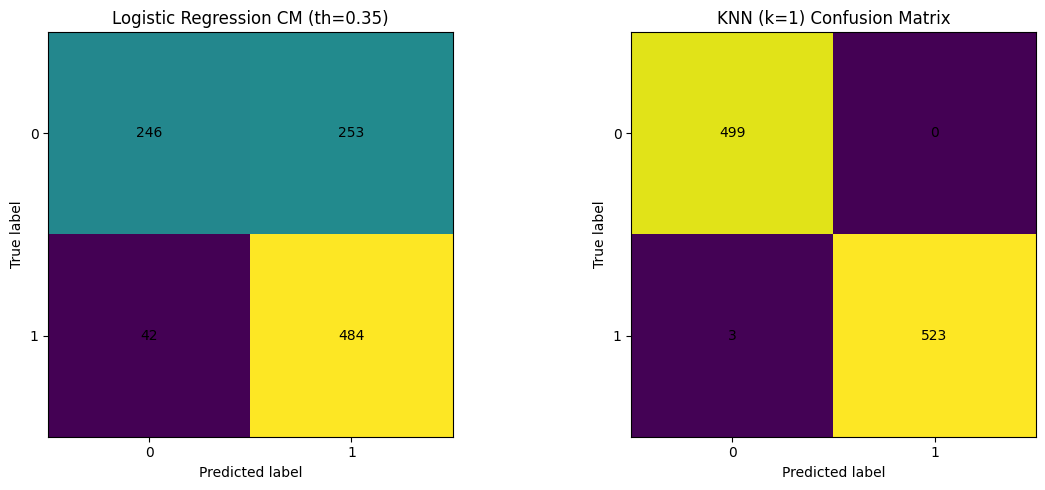

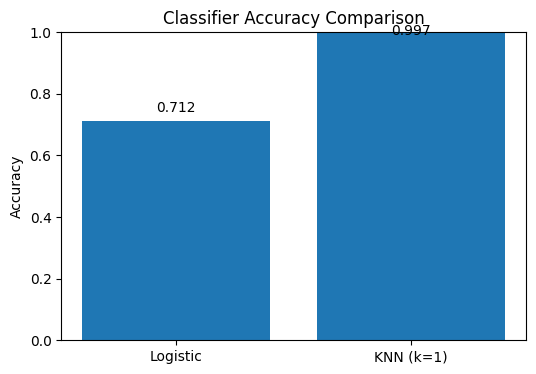


=== Logistic Regression (best config) metrics ===
Threshold: 0.35
Confusion matrix:
 [[246 253]
 [ 42 484]]
Accuracy: 0.7121951219512195
Precision: 0.6567164179104478
Recall: 0.9201520912547528
F1: 0.7664291369754552

=== KNN (k=1) metrics ===
Confusion matrix:
 [[499   0]
 [  3 523]]
Accuracy: 0.9970731707317073
Precision: 1.0
Recall: 0.9942965779467681
F1: 0.9971401334604385


In [ ]:
#-> this part was mostly AI , as i kept messing reading from the File T-T but i understood it
# 0) Guards
if best_config is None:
    raise RuntimeError(
        "best_config is None. The logistic grid search didn't set a best config. "
        "Make sure the grid loop ran and produced at least one row."
    )

if 'evaluate_fold_indices' not in globals():
    raise RuntimeError("evaluate_fold_indices(...) is not defined in scope.")

if 'evaluate_fold' not in globals():
    raise RuntimeError("evaluate_fold(...) is not defined in scope.")

# 1) Re-evaluate best logistic config across CV to get y_trues, y_probs, y_preds
#  use a dedicated StratifiedKFold to avoid accidental reuse of a plain KFold
from sklearn.model_selection import StratifiedKFold, KFold

kf_log = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_y_trues_list, log_y_probs_list = [], []

for tr_idx, vl_idx in kf_log.split(X_all_np, y_all_np):
    y_val_cpu, prob_val = evaluate_fold_indices(
        tr_idx, vl_idx,
        best_config['learning_rate'],
        best_config['epochs'],
        best_config['reg_l1'],
        best_config['reg_l2'],
        best_config['batch_size']
    )
    # Ensure cpu numpy arrays
    y_val_cpu = np.asarray(y_val_cpu).ravel()
    prob_val = np.asarray(prob_val)
    # Reduce to 1D proba for positive class if shape is (n,1) or (n,2)
    if prob_val.ndim == 2 and prob_val.shape[1] == 1:
        prob_val = prob_val[:, 0]
    elif prob_val.ndim == 2 and prob_val.shape[1] == 2:
        # assume column 1 is positive class
        prob_val = prob_val[:, 1]
    elif prob_val.ndim > 2:
        raise ValueError(f"Unexpected prob_val shape: {prob_val.shape}")
    log_y_trues_list.append(y_val_cpu)
    log_y_probs_list.append(prob_val)

if not log_y_trues_list or not log_y_probs_list:
    raise RuntimeError("No logistic CV predictions were collected.")

log_y_trues = np.concatenate(log_y_trues_list).astype(int)
log_y_probs = np.concatenate(log_y_probs_list).astype(float)

log_threshold = float(best_config.get('threshold', 0.5))
log_y_preds = (log_y_probs >= log_threshold).astype(int)

cm_log = confusion_matrix(log_y_trues, log_y_preds)
log_acc = accuracy_score(log_y_trues, log_y_preds)
log_prec = precision_score(log_y_trues, log_y_preds, zero_division=0)
log_rec = recall_score(log_y_trues, log_y_preds, zero_division=0)
log_f1 = f1_score(log_y_trues, log_y_preds)

# 2) Get best K from KNN results (prefer CSV, else in-memory)
csv_file = "All results KNN.csv"
df_results_knn = None
best_k = None

try:
    if os.path.exists(csv_file):
        import pandas as pd
        df_results_knn = pd.read_csv(csv_file)
        if "k" in df_results_knn.columns and "f1" in df_results_knn.columns and len(df_results_knn):
            best_k = int(df_results_knn.sort_values("f1", ascending=False).iloc[0]["k"])
except Exception as e:
    print(f"[WARN] Could not read '{csv_file}' due to: {e}")

if best_k is None:
    # Fallback to in-memory 'results' from your KNN loop if available
    if 'results' in globals() and isinstance(results, list) and len(results) > 0 and "k" in results[0] and "f1" in results[0]:
        best_k = int(sorted(results, key=lambda r: r["f1"], reverse=True)[0]["k"])
    else:
        raise RuntimeError(
            "Could not determine best_k for KNN. Make sure the KNN loop ran and either "
            "created 'All results KNN.csv' or kept an in-memory 'results' list with 'k' and 'f1'."
        )

# 3) Re-evaluate best KNN across CV for confusion matrix
kf_knn = KFold(n_splits=5, shuffle=True, random_state=42)

knn_y_trues_list, knn_y_preds_list = [], []

for tr_idx, vl_idx in kf_knn.split(X_all_np, y_all_np):
    y_val, prob_val, y_pred = evaluate_fold(tr_idx, vl_idx, best_k)
    y_val = np.asarray(y_val).ravel().astype(int)
    y_pred = np.asarray(y_pred).ravel().astype(int)
    if y_val.shape[0] != y_pred.shape[0]:
        raise ValueError(f"KNN fold size mismatch: y_val={y_val.shape}, y_pred={y_pred.shape}")
    knn_y_trues_list.append(y_val)
    knn_y_preds_list.append(y_pred)

knn_y_trues = np.concatenate(knn_y_trues_list).astype(int)
knn_y_preds = np.concatenate(knn_y_preds_list).astype(int)

cm_knn = confusion_matrix(knn_y_trues, knn_y_preds)
knn_acc = accuracy_score(knn_y_trues, knn_y_preds)
knn_prec = precision_score(knn_y_trues, knn_y_preds, zero_division=0)
knn_rec = recall_score(knn_y_trues, knn_y_preds, zero_division=0)
knn_f1 = f1_score(knn_y_trues, knn_y_preds)

# 4) Plot with pure matplotlib (no seaborn)
def plot_cm(ax, cm, title):
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    # Annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    return im

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
plot_cm(ax1, cm_log, f"Logistic Regression CM (th={log_threshold:.2f})")

ax2 = plt.subplot(1, 2, 2)
plot_cm(ax2, cm_knn, f"KNN (k={best_k}) Confusion Matrix")

plt.tight_layout()
plt.savefig("confusion_matrices_comparison.png", dpi=200)
plt.show()

# 5) Accuracy bar chart (pure matplotlib)
models = ["Logistic", f"KNN (k={best_k})"]
accuracies = [float(log_acc), float(knn_acc)]

plt.figure(figsize=(6, 4))
x = np.arange(len(models))
plt.bar(x, accuracies)
plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")

# annotate bars
for i, acc in enumerate(accuracies):
    plt.text(i, min(acc + 0.03, 0.99), f"{acc:.3f}", ha="center")

plt.savefig("accuracy_comparison.png", dpi=200)
plt.show()

# 6) Print summaries
print("\n=== Logistic Regression (best config) metrics ===")
print(f"Threshold: {log_threshold:.2f}")
print("Confusion matrix:\n", cm_log)
print("Accuracy:", log_acc)
print("Precision:", log_prec)
print("Recall:", log_rec)
print("F1:", log_f1)

print(f"\n=== KNN (k={best_k}) metrics ===")
print("Confusion matrix:\n", cm_knn)
print("Accuracy:", knn_acc)
print("Precision:", knn_prec)
print("Recall:", knn_rec)
print("F1:", knn_f1)


# Summery


- using KNN resulted in a higher overall score with 0.1 Logscore but using K = 1 in such small dataset would probably result in overfitting
  it took much less time , so i would probably stick to K = 3 or K = 2

- Logisitcregression took more time but its less prune to overfitting

- The dataset is really small to get any real accurate results ): 